<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/2c2025/ICDIC_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 2: Introducción a la Inferencia Estadística
**Objetivos:** Con este trabajo práctico se busca que los alumnos comiencen a familiarizarse con las herramientas de inferencia estadística para la obtención de los parámetros de un modelo (en este caso, funciones de distribución de probabilidad), y generar nuevas simulaciones de la variable de interés en base a datos.

**Librerías:** En este trabajo se utilizará

*   Numpy: matemática básica y definición de matrices y vectores; simulación de variables aleatorias
*   Seaborn: construcción de gráficos
*   Bambi: Librería basada en PyMC para la inferencia estadística utilizando cadenas de Markov

También necesitaremos de la librería ArviZ para ver los resultados de nuestra inferencia, al igual que Numpy.






In [ ]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import io

# graficos de residuos y qq-plots
import scipy
import statsmodels.api as sm

# para registrar el tiempo de corrida
import datetime

In [ ]:
def plot_residuos_1(dataframe,inference_data,y,num_pp_samples=np.nan,fig_size=(10,3)):
  # valores observados
  y_obs = inference_data.observed_data[y].values
  # valores predichos
  mu_est = inference_data.posterior['mu'].values

  residuos = y_obs - mu_est.mean(axis=(0,1))
  if np.isnan(num_pp_samples):
    num_pp_samples = len(dataframe)

  fig, ax = plt.subplots(1,2,figsize=fig_size)
  for i in range(0,num_pp_samples):
    residuals = y_obs - mu_est[0,i,:]
    sns.kdeplot(residuals, ax=ax[0], linewidth=.3, alpha=.3, color='C0' )

  sns.kdeplot(residuos, ax=ax[0], linewidth=1., color='k' )
  ax[0].axvline(x=0, linestyle='--', color='gray', linewidth=1.5)
  ax[0].grid(True)
  ax[0].set_xlabel('residuos')
  ax[0].set_xlim(np.min(-np.abs(residuos))*1.5,np.max(np.abs(residuos))*1.5)

  scipy.stats.probplot(residuos,plot=ax[1])

  return fig, ax

In [ ]:
def plot_residuos_2(dataframe,inference_data,y,x=None,hdi_prob=0.94,fig_size=(10,3)):
  # valores observados
  y_obs = inference_data.observed_data[y].values
  # valores predichos
  mu_est = inference_data.posterior['mu'].values

  residuos = y_obs - mu_est.mean(axis=(0,1))
  #if x is not None:
  #  residuos = residuos[np.argsort(dataframe[x].values)]
  #else:
  #  residuos = residuos[np.argsort(y_obs)]

  # eje X
  if x is None:
    x_obs = mu_est.mean(axis=(0,1))
  else:
    x_obs = dataframe[x].values

  fig, ax = plt.subplots(1,2,figsize=fig_size)
  for i in range(len(dataframe)):
    residuals = y_obs[i] - mu_est.mean(axis=(0,1))[i]
    quantiles = az.hdi(np.ravel(y_obs[i]-mu_est[:,:,i]),hdi_prob=hdi_prob)
    ax[0].plot( [x_obs[i],x_obs[i]], quantiles, color='gray', alpha=.3 )
    ax[0].plot( x_obs[i], residuals.mean(), 'o', color='C0', markersize=2)
  ax[0].axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
  ax[0].set_ylabel('residuo')
  if x is None:
    ax[0].set_xlabel(y)
  else:
    ax[0].set_xlabel(x)
  ax[0].grid(True)
  lim = np.max(np.abs(residuos))*1.5
  ax[0].set_ylim(-lim,lim)

  sm.graphics.tsa.plot_acf(residuos,ax[1])
  #if x is not None:
  #  ax[1].set_title('Autocorrelation - '+ ' ' + x)
  #else:
  #  ax[1].set_title('Autocorrelation - '+ ' ' + y)

  return fig, ax

In [ ]:
start_datetime = datetime.datetime.now()

print('Inicio de corrida: ',start_datetime)

Inicio de corrida:  2025-10-14 17:37:36.655534


Grupo:

Integrantes:

*   Apellido, Nombres XXXXXX
*   Apellido, Nombres XXXXXX
*   Apellido, Nombres XXXXXX
*   Apellido, Nombres XXXXXX
*   Apellido, Nombres XXXXXX

## Ejercicio 1: Preguntas conceptuales

#### Actividad 1

**Actividad**: Usted tiene dos chapas de acero, con un modelo de generación de datos Normal donde $\sigma$ representa errores de medición (cada chapa fue medida por muchas personas distintas) y $\mu$ es el espesor de la chapa.

¿Qué haría para evaluar si las dos chapas tienen efectivamente distinto espesor?

**Su respuesta**:

#### Actividad 2

**Actividad**: Usted tiene dos dosificaciones de hormigón, con un modelo de generación de datos Normal donde $\sigma$ representa la dispersión de resultados (la máquina de ensayo es perfecta, se ensayaron varias probetas) y $\mu$ el valor medio de la resistencia

¿Qué haría para evaluar si los hormigones tienen resistencias tangiblemente distintas?

**Su respuesta**:

### Actividad 3

**Actividad**: Se quiere ajustar una función de distribución para la cantidad de tornados en la provincia de Santa Fe. Adoptando un modelo generación de datos Poisson, $y\sim Po(λ)$, ¿cuáles de las siguientes distribuciones podrían ser utilizadas como distribución a priori para el parámetro λ? La solución se va a obtener en forma numérica mediante MCMC

1. $\lambda \sim N(1,0.1)$
2. $\lambda \sim LN(0,0.1)$
3. $\lambda \sim exp(1)$
4. $\lambda \sim Unif(0,\infty)$
5. $\log(\lambda) \sim N(0,0.1)$

**Su respuesta**:

### Actividad 4

Ajustamos unos datos con un modelo lognormal $Y\sim LN(y|\mu,\sigma)$. La distribución posterior de los parámetros es discreta,

$$p\left(\mu,\sigma|\mathbf{y}\right) = \begin{cases}0.2 & si& \mu=0.5,&\sigma = 0.1 \\ 0.5 & si& \mu=0,&\sigma=0.04 \\ 0.3&si&\mu=-0.5&\sigma=1.0 \end{cases}$$

Prediga el valor medio de nuevas observaciones de y

**Su respuesta**:

In [ ]:
# Sus cuentas


## Ejercicio 2: Evaluación de un tratamiento para el hormigón

Una empresa constructora quiere evaluar un nuevo proceso de curado y ver si tiene un efecto en la resistencia del hormigón. Para ello se tienen 7 pares de ensayos de probetas, unos con y otros sin tratamiento.

La empresa tiene las siguientes preguntas:

- ¿Los hormigones son distintos entre sí debido al tratamiento?
- ¿Cuál es la resistencia característica del hormigón según el tratamiento?
- ¿Puedo asegurar una mejora de $2MPa$ en la resistencia del hormigón en una viga cualquiera por efecto del tratamiento?

El objetivo del ejercicio es contestar estas preguntas.

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving hormigones_tratamiento_tp2.csv to hormigones_tratamiento_tp2.csv


In [ ]:
#Se crea un DataFrame
df = pd.read_csv(io.BytesIO(uploaded['hormigones_tratamiento_tp2.csv']))
df

,Resistencia,Tratamiento
0,30.9,No
1,33.3,No
2,33.5,No
3,36.2,No
4,37.2,No
5,37.6,No
6,38.2,No
7,34.2,Si
8,37.1,Si
9,39.6,Si


### Actividad 1

**Actividad**: Calcule el valor medio y el desvío estandar (muestral) de los hormigones con y sin tratamiento. Indique la cantidad de muestras de cada uno.

In [ ]:
# Cantidad de muestras
N = len(df)
print('Numero de muestras totales',N)

# Hormigón sin tratar
# CODIGO DEL ALUMNO ============================================================
h0_mean =
h0_std =
N0 =
# ==============================================================================

# Hormigón con tratamiento
# CODIGO DEL ALUMNO ============================================================
h1_mean =
h1_std =
N1 =
# ==============================================================================

print('Sin Tratamiento:',N0,'muestras')
print('Media',h0_mean,'desvio',h0_std)
print('Con Tratamiento:',N1,'muestras')
print('Media',h1_mean,'desvio',h1_std)

Numero de muestras totales 14
Sin Tratamiento: 7 muestras
Media 35.271428571428565 desvio 2.7299049346783053
Con Tratamiento: 7 muestras
Media 39.699999999999996 desvio 3.234192325759245


Debiera ver una diferencia de más de $4MPa$ en el valor medio.

### Construcción del Modelo

#### Actividad 2

**Actividad**: Asumiendo un modelo de generación de datos normal para la resistencia de las probetas, construya en `Bambi` un modelo de inferencia cuya variable explicativa sea la existencia del tratamiento.

In [ ]:
# Paso 1: modelo
# CODIGO DEL ALUMNO ============================================================
model_1 =
# ==============================================================================

model_1.build()
model_1.graph()

#### Actividad 3

**Actividad**: Explique qué significa cada parámetro de su modelo.

**Su respuesta**:

#### Actividad 4

**Actividad**: Muestre las distribuciones a priori adoptadas para los parámetros (ya sean definidas por ustedes o default). Haga las modificaciones que considere apropiadas si no le gustan/no reflejan lo que usted quiere.

In [ ]:
# Paso 2: prioris
# CODIGO DEL ALUMNO ============================================================

# ==============================================================================
plt.show()

#### Actividad 5

**Actividad**: Realice la inferencia mediante MCMC, mostrando visualmente las simulaciones de las cadenas. Indique si las mismas convergieron adecuadamente.

In [ ]:
# Paso 3: inferencia
# CODIGO DEL ALUMNO ============================================================
results_1 =
# ==============================================================================

In [ ]:
# Paso 4: resultados
# CODIGO DEL ALUMNO ============================================================

# Grafico




# Tabla

# ==============================================================================

**Su respuesta**:

### Distribución posterior de los parámetros

#### Actividad 6

**Actividad**: Muestre la distribución posterior de los parámetros con su intervalo de confianza de 90%.

In [ ]:
# Paso 4: posterior
# CODIGO DEL ALUMNO ============================================================

# Grafico




# Tabla

# ==============================================================================

#### Actividad 7

**Actividad**: En base los resultados, ¿puede afirmar que los hormigones son diferentes? Es decir, ¿los parámetros que explican la resistencia del hormigón con o sin tratamiento varían?

Muestre gráficamente con `az.plot_posterior` la diferencia en el valor medio entre hormigones, con un intervalo de confianza de 90%.

*NOTA*: Según el modelo, tal vez deba manipular las simulaciones primero para poder graficarlo, o tal vez lo que se pide sea directamente uno de los parámetros del modelo construido.

In [ ]:
results_1

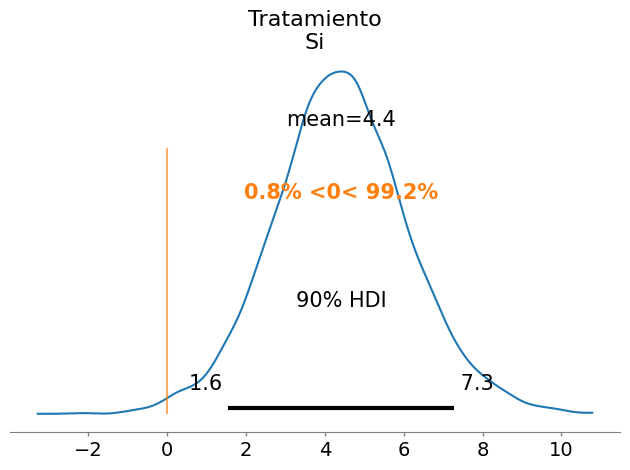

In [ ]:
# Paso 5: comparacion valores medios
# CODIGO DEL ALUMNO ============================================================

# Grafico




# ==============================================================================

**Su respuesta**:

### Distribución posterior predictiva

#### Actividad 8

**Actividad**: Construya un dataframe de nombre `df_new` con las muestras de hormigón que queremos predecir:

1. Un hormigón sin tratamiento
2. Un hormigón con tratamiento

In [ ]:
# Probetas a predecir

# CODIGO DEL ALUMNO ============================================================
df_new =
# ==============================================================================

df_new

,Tratamiento
0,No
1,Si


#### Actividad 9

**Actividad**: Para las probetas del nuevo dataset, prediga el valor medio de su resistencia y genere simulaciones de ensayos. Gráfique para cada muestra la densidad de probabilidad de su valor medio y del resultado de un ensayo.

*NOTA*: Puede hacerlo con el método `.predict` de `Bambi`, y luego con la función `az.plot_posterior`.

In [ ]:
# Predicción de las probetas

# CODIGO DEL ALUMNO ============================================================
results_new =
# ==============================================================================

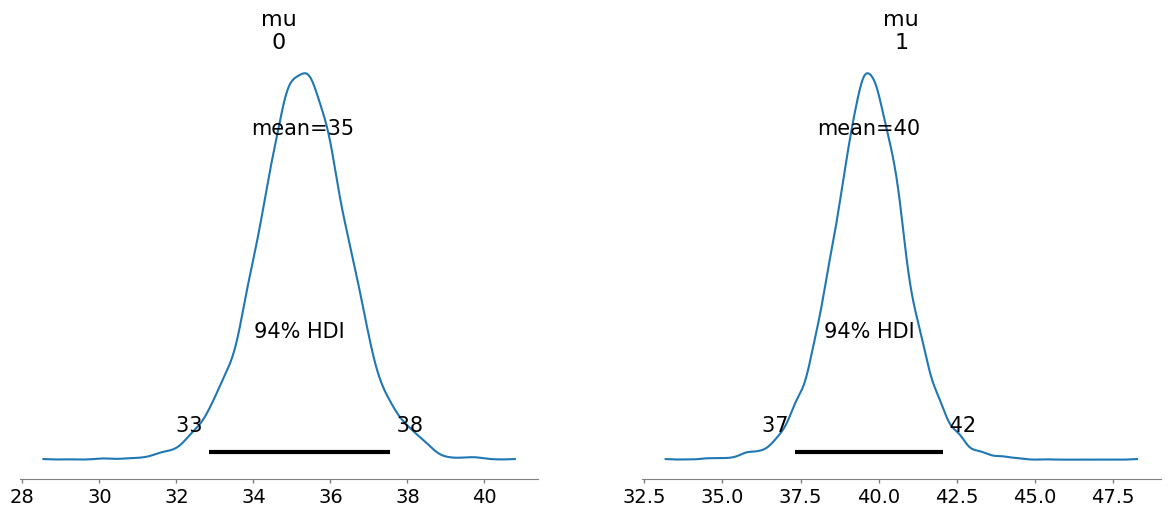

In [ ]:
# Valores medios de cada probeta

# CODIGO DEL ALUMNO ============================================================


# ==============================================================================

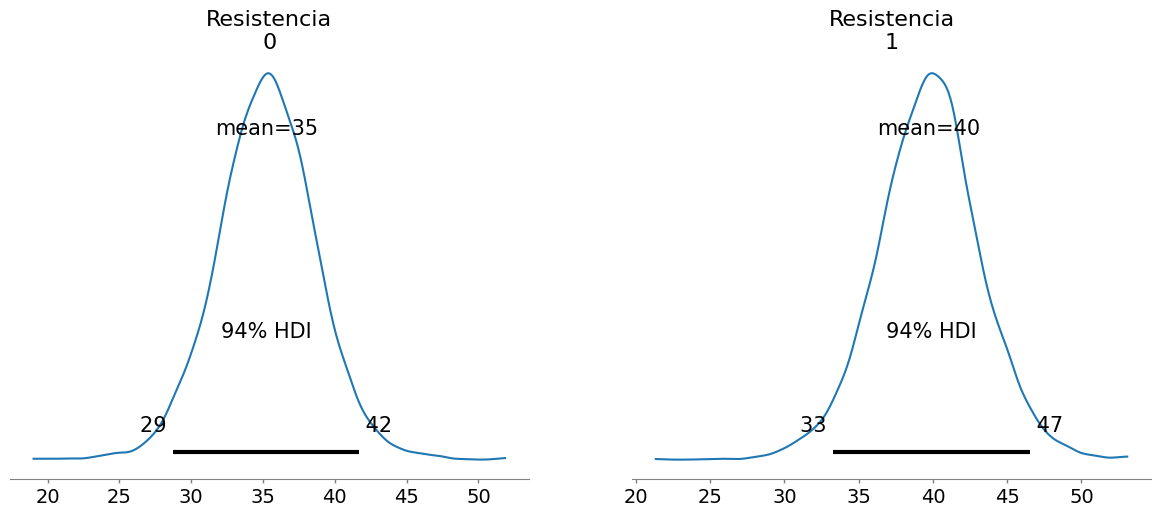

In [ ]:
# Simulaciones de resistencia de cada probeta

# CODIGO DEL ALUMNO ============================================================


# ==============================================================================

#### Actividad 10

**Actividad**: Compare los valores medios. ¿Puede afirmar que son distintos? Muéstrelo en forma gráfica.

*NOTA*: Estamos repitiendo la Actividad 7 vista de otra manera. Le conviene definir una vector con la diferencia de valores medios, y luego cargar eso en `az.plot_posterior`

In [ ]:
results_new

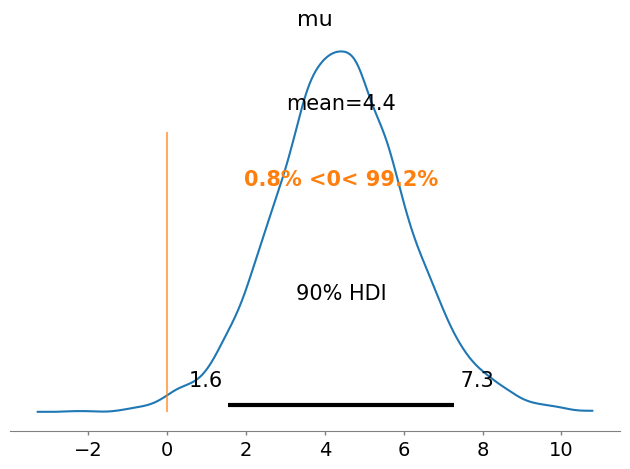

In [ ]:
# Paso 5: comparacion valores medios
# CODIGO DEL ALUMNO ============================================================

# Diferencia
diff =

# Grafico



# ==============================================================================

**Su respuesta**:

#### Actividad 11

**Actividad**: Compare los valores de resistencia. ¿Puede afirmar que el tratamiento aumenta la misma 2 MPa?

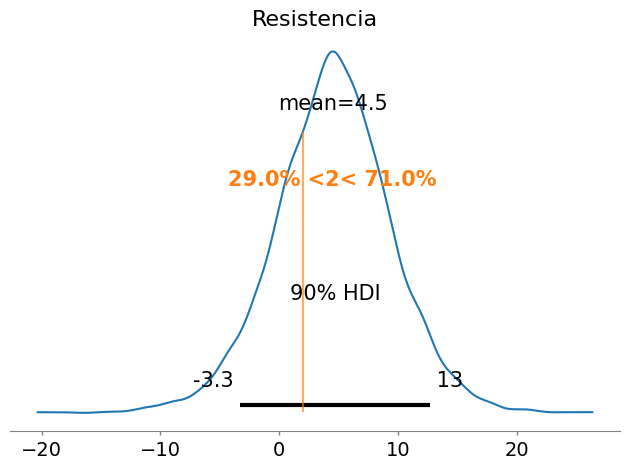

In [ ]:
# Paso 6: comparacion de resistencias
# CODIGO DEL ALUMNO ============================================================

# Diferencia
diff =

# Grafico



# ==============================================================================

**Su respuesta**:

#### Actividad 12

**Actividad**: Calcule para cada hormigón su resistencia característica (su cuantil 0.10)

In [ ]:
# Paso 7: f'c
# CODIGO DEL ALUMNO ============================================================

# Resistencias caracteristicas
fc_0 =
fc_1 =

# ==============================================================================
print('Resistencia característica sin tratamiento:',np.round(fc_0,2),'MPa')
print('Resistencia característica con tratamiento:',np.round(fc_1,2),'MPa')

Resistencia característica sin tratamiento: 30.94 MPa
Resistencia característica con tratamiento: 35.36 MPa


## Ejercicio 3: El mejor grado de polinomio para un dataset

El primer ejercicio tiene como objetivo replicar los gráficos vistos en clase de ajuste de polinomios. Simplemente vamos a cargar los modelos para ir viendo distintas formas de hacerlo, y luego seleccionaremos un modelo para predecir datos nuevos.

El objetivo es contestar la siguiente pregunta: ¿Cuál es la probabilidad de que $y>0$ dado $x=15$?

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving synthetic_tp3_poly.csv to synthetic_tp3_poly.csv


In [ ]:
#Se crea un DataFrame
df_poly = pd.read_csv(io.BytesIO(uploaded['synthetic_tp3_poly.csv']))
df_poly.head()

,X,y
0,12.662012,2.704232
1,25.476867,-5.203239
2,26.503127,-4.006719
3,22.844023,-5.043336
4,13.074301,1.797265


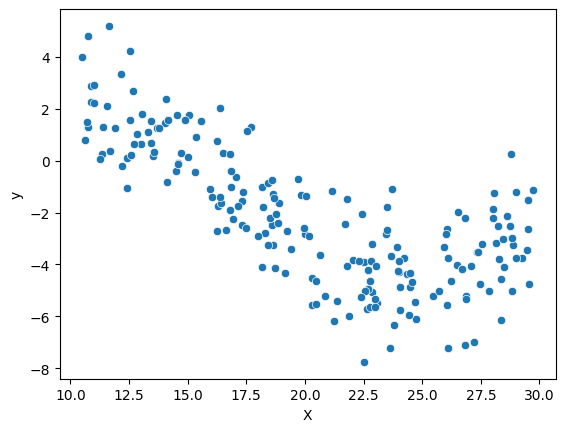

In [ ]:
sns.scatterplot(df_poly,x='X',y='y')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

### Ajuste como recta (p=1)

#### Actividad 1

**Actividad**: Ajuste en `Bambi` una recta $y = A\ X +B$ a partir de los datos. Es decir, obtenga las distribuciones posteriores de los parámetros del siguiente modelo de generación de datos:

$$y|X\sim N\left(\mu=A\ X+B,\sigma=\sigma\right)$$

In [ ]:
# CODIGO DEL ALUMNO ############################################################
model_lin =
################################################################################

model_lin.build()
model_lin.graph()

A continuación puede ver un resumen de los parámetros del modelo con sus IC:

Output()

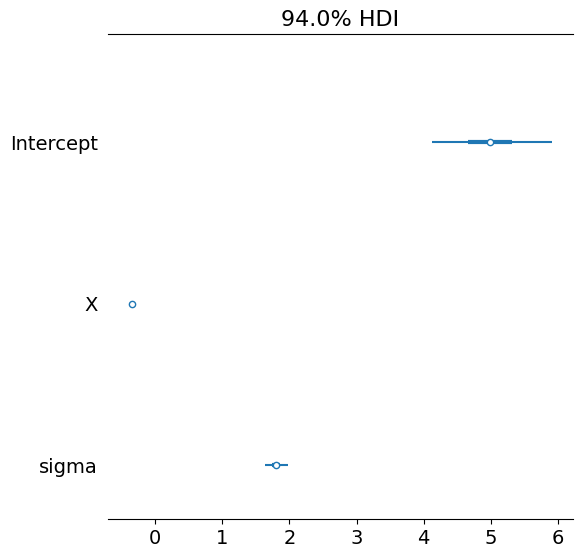

In [ ]:
# Obtencion de simulaciones de la posterior
results_lin = model_lin.fit(chains=4,draws=2000)

# Parámetros del modelo
az.plot_forest(results_lin,combined=True)
plt.show()

Y, a continuación, puede ver el ajuste en función de $X$

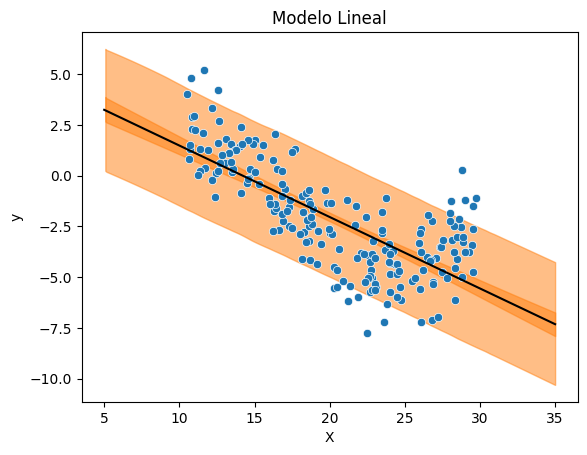

In [ ]:
# Hacer simulaciones para nuevos valores de X
pd_new = pd.DataFrame({'X':np.linspace(5,35,101)})

# Prediccion de datos no observados
new_lin = model_lin.predict(results_lin,data=pd_new,inplace=False,kind="response")

# Una visualización de ejemplo
az.plot_hdi(pd_new.X,new_lin.posterior['mu'],hdi_prob=0.9)
az.plot_hdi(pd_new.X,new_lin.posterior_predictive['y'],hdi_prob=0.9)
plt.plot(pd_new.X,new_lin.posterior['mu'].mean(axis=(0,1)),color='k')
sns.scatterplot(df_poly,x='X',y='y')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Modelo Lineal')
plt.show()

### Ajuste como parábola (p=2)

#### Actividad 2

**Actividad**: Ajuste en `Bambi` una parábola $y = A\ X^{2} + B\ X +C$ a partir de los datos. Es decir, obtenga las distribuciones posteriores de los parámetros del siguiente modelo de generación de datos:

$$y|X\sim N\left(\mu=A\ X^{2} + B\ X + C,\sigma=\sigma\right)$$


*NOTA: Usando llaves en la fórmula de* `Bambi` *es posible generar variables nuevas. Por ejemplo* `{X+3}` *crea un nuevo dato* $X+3$ *sin necesidad de generar una nueva columna en el dataframe. Esto le puede servir para incorporar la componente cuadrática*

In [ ]:
# CODIGO DEL ALUMNO ############################################################
model_quad =
################################################################################

model_quad.build()
model_quad.graph()

Output()

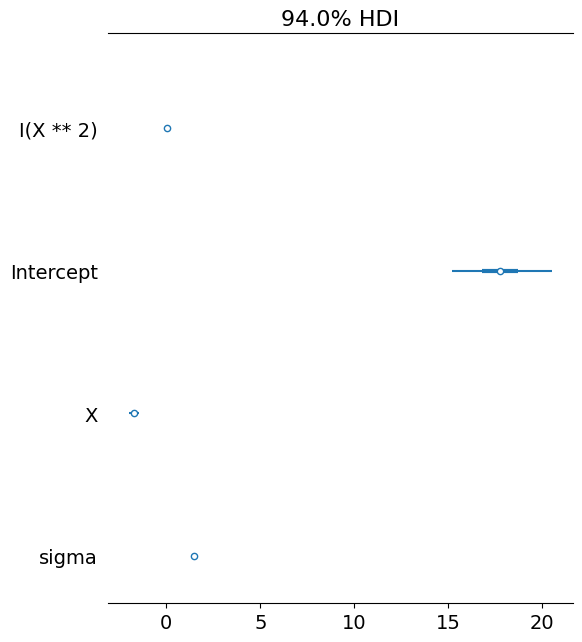

In [ ]:
# Obtencion de simulaciones de la posterior
results_quad = model_quad.fit(chains=4,draws=2000)

# Parámetros del modelo
az.plot_forest(results_quad,combined=True)
plt.show()

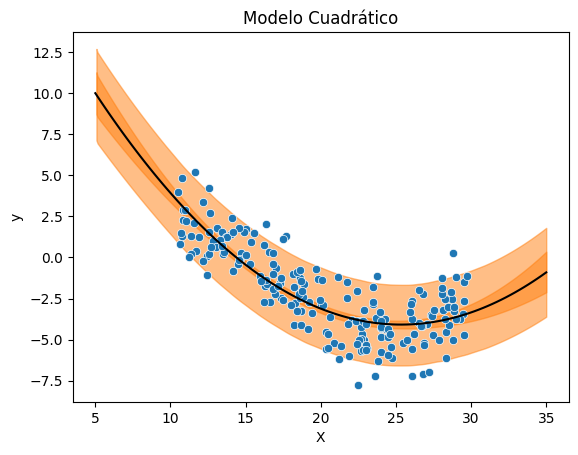

In [ ]:
# Prediccion de datos no observados
new_quad = model_quad.predict(results_quad,data=pd_new,inplace=False,kind="response")

# Una visualización de ejemplo
az.plot_hdi(pd_new.X,new_quad.posterior['mu'],hdi_prob=0.9)
az.plot_hdi(pd_new.X,new_quad.posterior_predictive['y'],hdi_prob=0.9)
plt.plot(pd_new.X,new_quad.posterior['mu'].mean(axis=(0,1)),color='k')
sns.scatterplot(df_poly,x='X',y='y')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Modelo Cuadrático')
plt.show()

### Ajuste como cúbica (p=3)

#### Actividad 3

**Actividad**: Ajuste en `Bambi` una cúbica $y = A\ X^{3} + B\ X^{2} +C\ X +D$ a partir de los datos. Es decir, obtenga las distribuciones posteriores de los parámetros del siguiente modelo de generación de datos:

$$y|X\sim N\left(\mu=A\ X^{3} + B\ X^{2} +C\ X +D,\sigma=\sigma\right)$$

In [ ]:
# CODIGO DEL ALUMNO ############################################################
model_cube =
################################################################################

model_cube.build()
model_cube.graph()

Output()

ERROR:pymc.stats.convergence:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


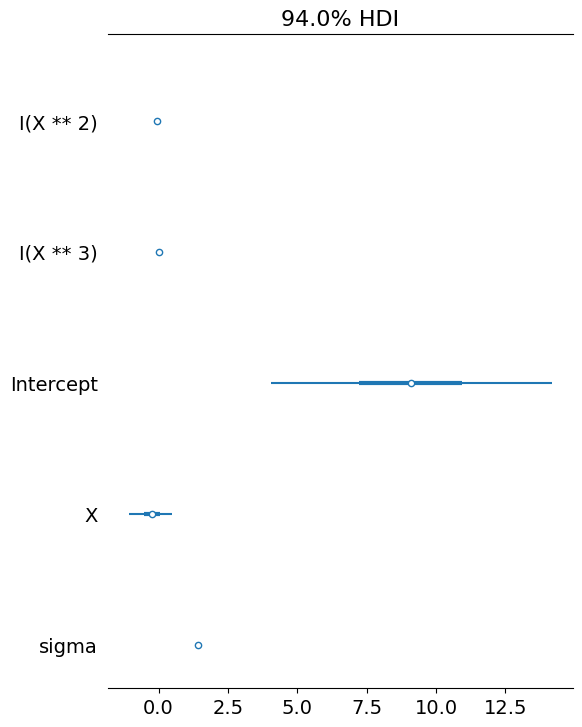

In [ ]:
# Obtencion de simulaciones de la posterior
results_cube = model_cube.fit(chains=4,draws=2000)

# Parámetros del modelo
az.plot_forest(results_cube,combined=True)
plt.show()

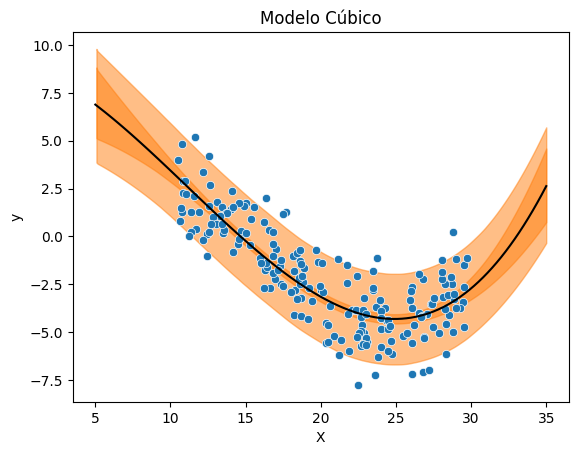

In [ ]:
# Prediccion de datos no observados
new_cube = model_cube.predict(results_cube,data=pd_new,inplace=False,kind="response")

# Una visualización de ejemplo
az.plot_hdi(pd_new.X,new_cube.posterior['mu'],hdi_prob=0.9)
az.plot_hdi(pd_new.X,new_cube.posterior_predictive['y'],hdi_prob=0.9)
plt.plot(pd_new.X,new_cube.posterior['mu'].mean(axis=(0,1)),color='k')
sns.scatterplot(df_poly,x='X',y='y')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Modelo Cúbico')
plt.show()

### Ajuste con polinomio de orden 4 (p=4)

#### Actividad 4

**Actividad**: Ajuste en `Bambi` un polinomio de orden 4 $y(x)$ a partir de los datos.

*Nota: Para polinomios de mayor grado, es mejor reescribir la ecuación en como suma de polinomios ortogonales entre sí (va a converger mucho más rápido. En* `Bambi`*, pueden hacerlo escribiendo* `poly(X,p)`*donde* $p$ *es el orden del polinomio a considerar para la variable* $X$

In [ ]:
# CODIGO DEL ALUMNO ############################################################
model_cuar =
################################################################################

model_cuar.build()
model_cuar.graph()

Output()

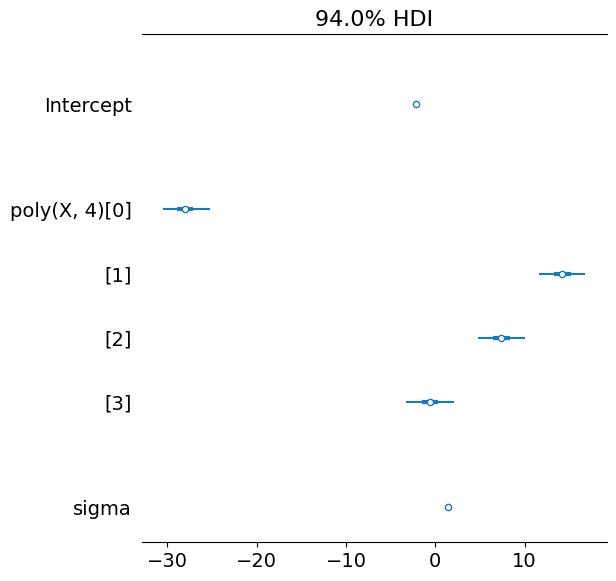

In [ ]:
# Obtencion de simulaciones de la posterior
results_cuar = model_cuar.fit(chains=4,draws=2000)

# Parámetros del modelo
az.plot_forest(results_cuar,combined=True)
plt.show()

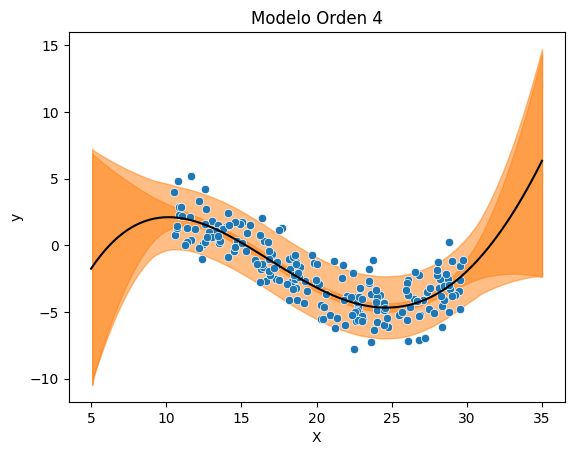

In [ ]:
# Prediccion de datos no observados
new_cuar = model_cuar.predict(results_cuar,data=pd_new,inplace=False,kind="response")

# Una visualización de ejemplo
az.plot_hdi(pd_new.X,new_cuar.posterior['mu'],hdi_prob=0.9)
az.plot_hdi(pd_new.X,new_cuar.posterior_predictive['y'],hdi_prob=0.9)
plt.plot(pd_new.X,new_cuar.posterior['mu'].mean(axis=(0,1)),color='k')
sns.scatterplot(df_poly,x='X',y='y')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Modelo Orden 4')
plt.show()

### Ajuste con polinomio de orden 7 (p=7)

#### Actividad 5

**Actividad**: Ajuste en `Bambi` un polinomio de orden 7 para $y(x)$ a partir de los datos.

In [ ]:
# CODIGO DEL ALUMNO ############################################################
model_sept =
################################################################################

model_sept.build()
model_sept.graph()

Output()

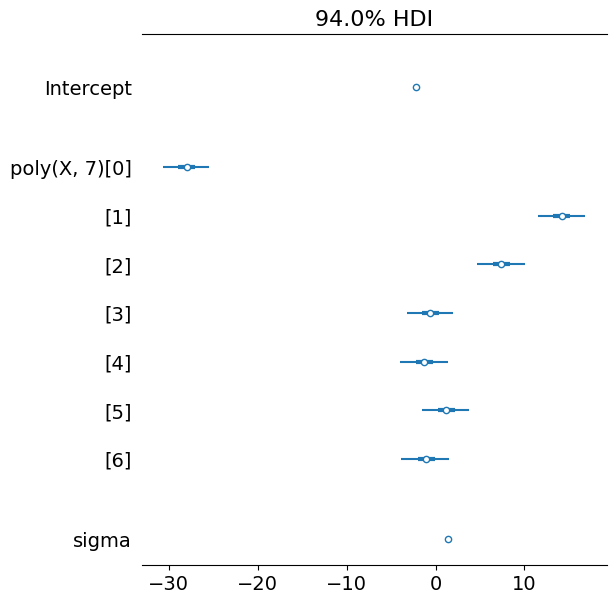

In [ ]:
# Obtencion de simulaciones de la posterior
results_sept = model_sept.fit(chains=4,draws=2000)

# Parámetros del modelo
az.plot_forest(results_sept,combined=True)
plt.show()

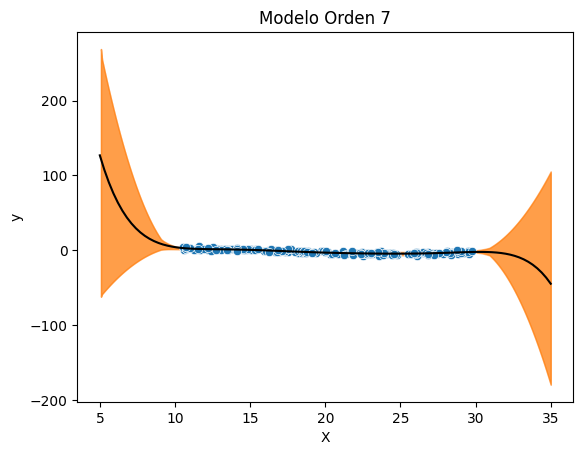

In [ ]:
# Prediccion de datos no observados
new_sept = model_sept.predict(results_sept,data=pd_new,inplace=False,kind="response")

# Una visualización de ejemplo
az.plot_hdi(pd_new.X,new_sept.posterior['mu'],hdi_prob=0.9)
az.plot_hdi(pd_new.X,new_sept.posterior_predictive['y'],hdi_prob=0.9)
plt.plot(pd_new.X,new_sept.posterior['mu'].mean(axis=(0,1)),color='k')
sns.scatterplot(df_poly,x='X',y='y')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Modelo Orden 7')
plt.show()

### Selección de modelos

Habiendo construido 5 posibles modelos para describir la relación entre $x$ e $y$, veamos cuál es el que mejor se ajusta a los datos. Nuestro objetivo es contestar eso mediante PSISLOO-CV, estimando la capacidad predictiva "out-of-sample" de los modelos.

Como no lo hicimos durante la inferencia (o si, dependerá de lo que hicieron ustedes), a continuación les dejamos una función para calcular las log-verosimilitudes.

In [ ]:
# Log verosimilitud modelo 1
model_lin.compute_log_likelihood(results_lin)

# Log verosimilitud modelo 2
model_quad.compute_log_likelihood(results_quad)

# Log verosimilitud modelo 3
model_cube.compute_log_likelihood(results_cube)

# Log verosimilitud modelo 4
model_cuar.compute_log_likelihood(results_cuar)

# Log verosimilitud modelo 7
model_sept.compute_log_likelihood(results_sept)

#### Actividad 6

**Actividad**: Compare la capacidad predictiva de los modelos y elija en consecuencia el modelo con el que usted se quedaría para predecir nuevos datos. Guárdelo en una variable `model_final` y los resultados de la inferencia en `results_final`.

In [ ]:
# CODIGO DEL ALUMNO ############################################################



################################################################################
comp

In [ ]:
# CODIGO DEL ALUMNO ############################################################

################################################################################
plt.show()

In [ ]:
# CODIGO DEL ALUMNO ############################################################
model_final =
results_final =
################################################################################

#### Actividad 7

**Actividad**: Conteste las siguientes preguntas:
- ¿Qué modelo tiene la mayor capacidad de predecir los datos vistos?
- ¿Qué modelo estima que tiene la mayor capacidad de predecir los datos no vistos?
- Si estos no coinciden, ¿por qué? ¿Qué está pasando?
- ¿El mejor modelo es significativamente mejor que el resto?
- ¿Usaría el modelo para extrapolar a rangos de $X$ no vistos?

**Su respuesta**:

### Análisis de residuos

A continuación se presenta el análisis de residuos de su modelo seleccionado.

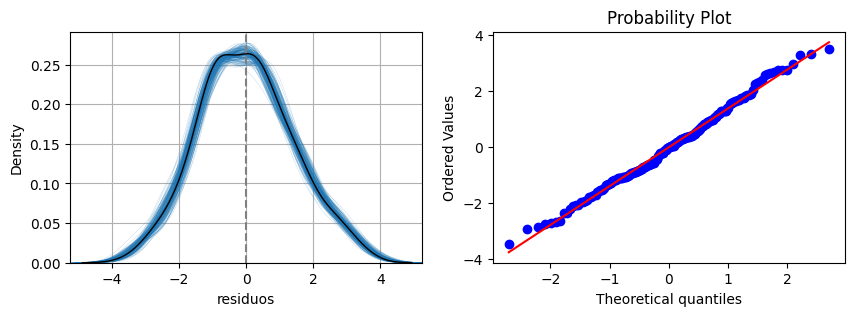

In [ ]:
fig, ax = plot_residuos_1(df_poly,results_final,'y')
plt.show()

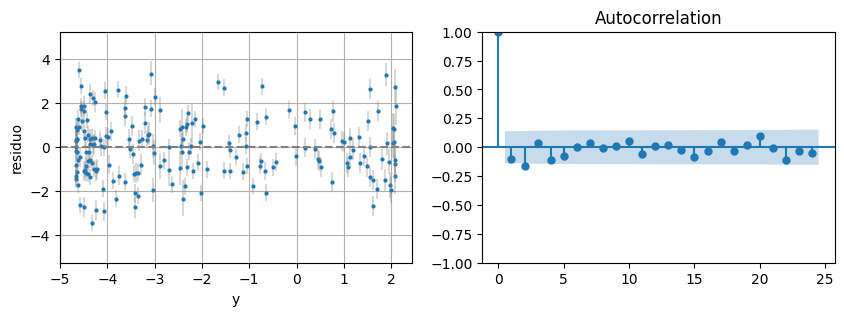

In [ ]:
fig, ax = plot_residuos_2(df_poly,results_final,'y')
plt.show()

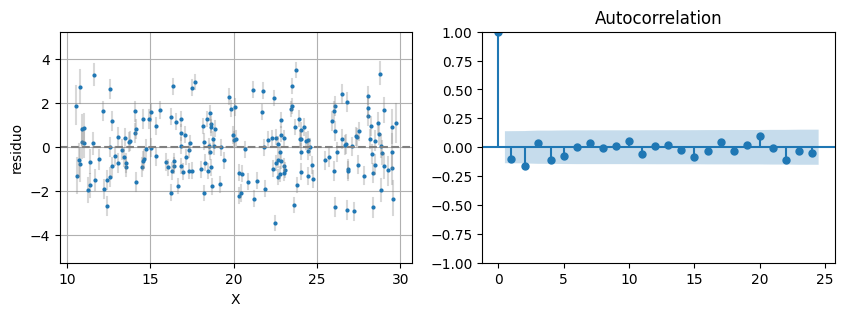

In [ ]:
fig, ax = plot_residuos_2(df_poly,results_final,'y','X')
plt.show()

#### Actividad 8

**Actividad**: En base a los gráficos anteriores, ¿considera que su modelo es apropiado? Explique.

**Su respuesta**:

### Uso del modelo

Finalmente, si estamos contentos con el modelo podemos usarlo para contestar la pregunta:

- ¿Cuál es la probabilidad de que $y>0$ dado $x=15.0$?

#### Actividad 9

**Actividad**: Conteste la pregunta a partir de nuevas simulaciones.

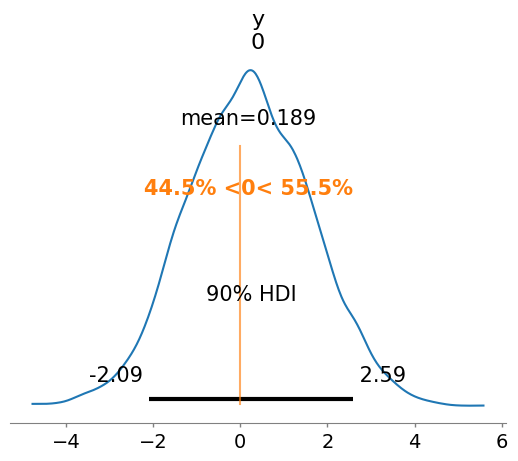

La probabilidad de que y>0 cuando X=15.0 es  55.5 %


In [ ]:
# CODIGO DEL ALUMNO ############################################################
pd_new =

# Prediccion de datos no observados
new_results =

# Una visualización de ejemplo


P_y =
################################################################################

print('La probabilidad de que y>0 cuando X=15.0 es ',np.round(P_y*100,1),'%')

## Ejercicio 4: Período Natural de edificios aporticados de acero

Se quieren verificar las ecuaciones presentes en el Reglamento ASCE-7 de Estados Unidos (en el cual se basa la línea CIRSOC Argentina) para estimar el período natural de edificaciones de acero. El trabajo original y su propuesta corresponde a Goel y Chopra, 1997 ([Link](https://ascelibrary.org/doi/10.1061/%28ASCE%290733-9445%281997%29123%3A11%281454%29))

### Carga del Dataset



In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving GoelChopraPeriod.csv to GoelChopraPeriod.csv


In [ ]:
#Se crea un DataFrame
df_chopra = pd.read_csv(io.BytesIO(uploaded['GoelChopraPeriod.csv']))
df_chopra.head()

,Structure,No.,Location,ID number,No. of Stories,Height [ft],Width [ft],Length [ft],Ac [sq ft],Ae [%],Earthquake,PGA [g],PGA > 0.15g,Period T [s],Direction
0,RC MRF,1,Emeryville,NaN,30.0,300.0,NaN,NaN,NaN,NaN,Loma Prieta,NaN,No,2.8,Longitudinal
1,RC MRF,2,Los Angeles,NaN,9.0,120.0,NaN,NaN,NaN,NaN,San Fernando,NaN,No,1.4,Longitudinal
2,RC MRF,3,Los Angeles,NaN,14.0,160.0,NaN,NaN,NaN,NaN,San Fernando,NaN,No,1.8,Longitudinal
3,RC MRF,4,Los Angeles,NaN,13.0,166.0,NaN,NaN,NaN,NaN,San Fernando,NaN,No,1.9,Longitudinal
4,RC MRF,5,Los Angeles,ATC_12,10.0,137.5,NaN,NaN,NaN,NaN,San Fernando,NaN,No,1.4,Longitudinal


In [ ]:
df_chopra = df_chopra.rename(columns={"Period T [s]": "T_s", "PGA > 0.15g": "PGA","No. of Stories":"N","Height [ft]":"Height"})
df_chopra_red = df_chopra[['T_s','N','Height','Structure','PGA']]

df_chopra_red.head()

,T_s,N,Height,Structure,PGA
0,2.8,30.0,300.0,RC MRF,No
1,1.4,9.0,120.0,RC MRF,No
2,1.8,14.0,160.0,RC MRF,No
3,1.9,13.0,166.0,RC MRF,No
4,1.4,10.0,137.5,RC MRF,No


Como puede ver, el dataset tiene los siguientes datos de interés para este ejercicio:
- Structure : La tipología estructural. A nosotros nos va a importar `Steel MRF` (estructuras aporticadas de acero) y `RC MRF` (estructuras aporticadas de hormigón.
- No. of Stories: Cantidad de pisos
- Height: Altura del edificio en pies
- PGA>0.15g: Indica si el sisma fue de intensidad moderada (en función de la máxima aceleración registrada)
- Period T [s]: El período natural medido en segundos

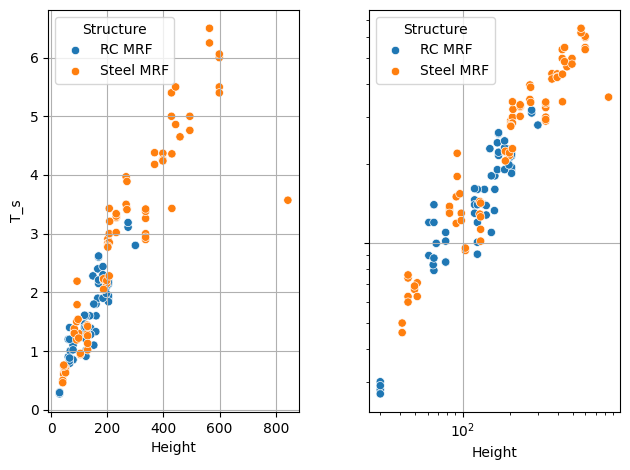

In [ ]:
fig, (axs) = plt.subplots(1, 2)
sns.scatterplot(data=df_chopra_red[(df_chopra_red['Structure']=='Steel MRF')|(df_chopra_red['Structure']=='RC MRF')].dropna(),x='Height',y='T_s',hue='Structure',ax=axs[0])
sns.scatterplot(data=df_chopra_red[(df_chopra_red['Structure']=='Steel MRF')|(df_chopra_red['Structure']=='RC MRF')].dropna(),x='Height',y='T_s',hue='Structure',ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid(True)
axs[1].grid(True)
plt.tight_layout()
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

#### Actividad 1
**Actividad**: Viendo los gráficos anteriores, ¿qué tipo de relación hay entre el período y la altura? ¿Diría que la misma depende de la tipología estructural?

**Su respuesta**:

### Construcción del modelo

El modelo propuesto para este tipo de problemas habitualmente es el modelo lognormal:

$$T \sim LN(m,s)$$

donde la función para la mediana $e^{m}$ sigue la forma

$$e^{m}=x_{1} \cdot H^{x_{2}}$$

Tomando el logaritmo, puedo calibrar el modelo como un modelo normal:

$$\log T \sim N(m,s)$$

donde el valor medio del logaritmo de los períodos es:

$$m = \log x_{1} + x_{2} \log H$$

En este caso, queremos testear la influencia de la tipología estructural, por lo tanto queremos que $X_{1}$ y $x_{2}$ sean función de ella:

$$m = \log x_{1,structure} + x_{2,structure} \log H$$



#### Actividad 2
**Actividad:** Viendo el modelo a construir, ¿qué implica que X_{1} dependa de la tipología estructural para el logaritmo de período?

**Su respuesta**:

#### Actividad 3
**Actividad:** Viendo el modelo a construir, ¿qué implica que $x_{2}$ dependa de la tipología estructural para el logaritmo del período? ¿Por qué decimos que hay un término de interacción?

**Su respuesta**:

#### Actividad 4

**Actividad**: Construya un modelo normal para el logaritmo de los períodos (es decir, un modelo lognormal) que permita ver la influencia de la tipología estructural.

In [ ]:
# Paso 1: modelo
# CODIGO DEL ALUMNO ============================================================
model_2 =
# ==============================================================================

model_2.build()
model_2.graph()

#### Actividad 5

**Actividad**: Muestre las distribuciones a priori adoptadas para los parámetros (ya sean definidas por ustedes o default). Haga las modificaciones que considere apropiadas si no le gustan/no reflejan lo que usted quiere.

In [ ]:
# Paso 2: prioris
# CODIGO DEL ALUMNO ============================================================

# ==============================================================================
plt.show()

#### Actividad 6

**Actividad**: Realice la inferencia mediante MCMC, mostrando visualmente las simulaciones de las cadenas. Indique si las mismas convergieron adecuadamente.

In [ ]:
# Paso 3: inferencia
# CODIGO DEL ALUMNO ============================================================
results_2 =
# ==============================================================================

In [ ]:
# Paso 4: resultados
# CODIGO DEL ALUMNO ============================================================

# Grafico




# Tabla

# ==============================================================================

**Su respuesta**:

### Distribución posterior de los parámetros

#### Actividad 7

**Actividad**: Muestre la distribución posterior de los parámetros con su intervalo de confianza de 68%.

In [ ]:
# Paso 4: posterior
# CODIGO DEL ALUMNO ============================================================

# Grafico




# Tabla

# ==============================================================================

#### Actividad 8
**Actividad**: En base los datos y el modelo elegido, ¿$x_{1}$ y $x_{2}$ dependen significativamente de la tipología estructural? Explique.

**Su respuesta**:

### Distribución posterior predictiva

#### Actividad 9

**Actividad**: Muestre un gráfico con los datos utilizados, y la curva de predicción de su modelo (con un intervalo de confiaza del 68%). Es decir, muestre cómo predice su modelo en función de la altura y si el modelo se ajusta a los datos.

NOTA: Esto puede hacerlo con la función de `Bambi` `interpret.plot_predictions`. Como su función esta hecha para el logaritmo de T, puede utilizar la variable `transforms` para volver a la escala original, o directamente hacer el gráfico para el logaritmo. Lo que usted prefiera.

`transforms={'log(T_s)': lambda x: np.exp(x)}`

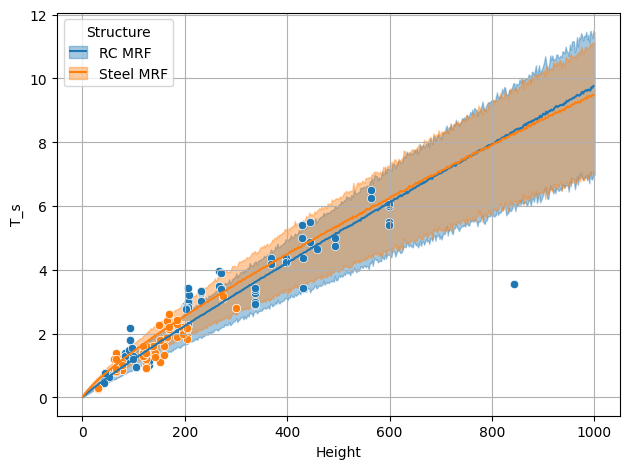

In [ ]:
# Paso 4: posterior predictiva
# CODIGO DEL ALUMNO ============================================================








# ==============================================================================

#### Actividad 10
**Actividad:** ¿Cómo nota la influencia de la estructura al vover a la escala original? ¿El modelo parece ajustarse a los datos? Comente repsecto a la forma de la función así como para la componente de error.

**Su respuesta**:

### Uso del modelo

Usted tiene un edificio de acero de 12 pisos (120ft) en California, y quiere conocer su período natural a considerar durante el sismo de diseño (`PGA=Yes`), ya que este influye en las cargas para el cual habrá que diseñarlo.

#### Actividad 11

**Actividad**: Con su modelo, obtenga un limite inferior del período natural de su edificio tal que la probabilidad de que ese período sea superado sea de 84%.

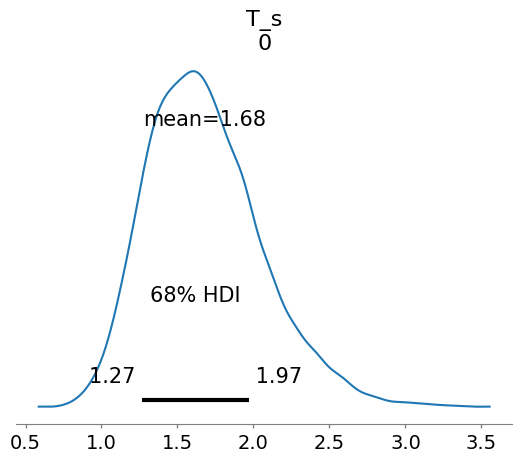

El período de diseño del edificio es de 1.31 segundos


In [ ]:
# CODIGO DEL ALUMNO ############################################################
pd_new

# Prediccion de datos no observados




# Una visualización de ejemplo


T_dis =
################################################################################

print('El período de diseño del edificio es de',np.round(T_dis,2),'segundos')

#### Actividad 12

**Actividad**: Compare su resultado con la predicción provista por los reglamentos norteamericanos

$$T_{a} = 0.028\cdot H^{0.8}$$

In [ ]:
# CODIGO DEL ALUMNO ############################################################
T_a =

DeltaT =
################################################################################

print('La estimación reglamentaria para el edificio es de ',np.round(T_a,2),'segundos')
print('La diferencia porcentual es de ',np.round(DeltaT*100,2),'%')

La estimación reglamentaria para el edificio es de  1.29 segundos
La diferencia porcentual es de  1.84 %


## Ejercicio 5: Construcción de modelos para el TP Integrador

El último ejercicio del trabajo práctico (y de todos los TPs de acá en más) es el avance del TP integrador. En este caso, el objetivo es proponer un modelo explicativo para los datos.

**NOTA**: Si su dataset no se presta a un modelo de regresión (es un problema de clasificación, por ejemplo), **hable con su ayudante** respecto a la actividad a realizar que supla la descripta acá abajo, que puede abarcar el diseño conceptual de los modelos que se verán más adelante en curso.

### Actividad 1

**Actividad**: Ajuste un modelo a la variable de interés de su dataset. Explique los parámetros del modelo y el modelo de generación de datos elegido. Muestre sus distribuciones posteriores y muestre cómo funciona (qué predice para disintos valores).

Vea si los modelos parecen ajustarse a los datos. Compare entre ellos según su capacidad predictiva y comience el proceso de mejora y selección en base a análisis de residuos y chequeos posteriores.

# Entrega del Trabajo Práctico

Para la entrega del TP2, siga los siguientes pasos:
1. Vuelva a correr el Colab desde 0 para asegurar que no haya ningún bug y todo funcione tal como se desea (`Disconnect and delete runtime`,`run all`)
2. Revise que todos los resultados estén presentes y como ustedes esperaban.
3. Asegúrese haber contestado todas la preguntas que requieren prosa.
4. Descargue el arcihvo .ipynb en su computadora
5. Incluya en la entrega el archivo generado como dataset en QGIS (las nuevas capas que haya creado o editado).

Revise que está todo como les gusta y ¡ya está listo! Ustedes son responables de que la entrega refleje sus intenciones, más allá de que nosotros podamos correr su archivo para revisar.

Los datos presentados abajo intentan ser para ustedes (y para nosotros) una verificación de que efectivamente han hecho la revisión final.

In [ ]:
print('Inicio de corrida: ',start_datetime)

end_datetime = datetime.datetime.now()
print('Fin de corrida: ',end_datetime)

elapsed_time = end_datetime-start_datetime
print('Tiempo de ejecución: ',round(elapsed_time.total_seconds()/60,1),'minutos')

Inicio de corrida:  2025-10-14 17:37:36.655534
Fin de corrida:  2025-10-14 17:50:11.045473
Tiempo de ejecución:  12.6 minutos
